In [1]:
input_file = 'data.csv'
output_file = 'data_5.csv'

with open(input_file, encoding='cp1251') as fin, \
     open(output_file, 'w', encoding='cp1251') as fout:

    for i, line in enumerate(fin):
        if i >= 1:
            break
        fout.write(line)

In [2]:
filename = '315_0.csv'
encoding = 'cp1251'
delimiter = ';'  # ← измените на ',' если нужно

with open(filename, encoding=encoding) as f:
    for i in range(2):  # первые две строки
        line = f.readline()
        if not line:
            break
        # Убираем символы новой строки и делим
        columns = line.rstrip('\r\n').split(delimiter)
        if columns:  # если строка не пустая
            last_col = columns[-2]
            print(f"Строка {i+1}, последний столбец: {repr(last_col)}")
        else:
            print(f"Строка {i+1} пустая")

Строка 1, последний столбец: 'NUM65536'
Строка 2, последний столбец: '37.923006190591686'


In [9]:
def count_lines(filename, encoding='cp1251'):
    with open(filename, encoding=encoding) as f:
        return sum(1 for _ in f)

total = count_lines('315_1.csv')
print(f"Всего строк в файле: {total}")

Всего строк в файле: 67


Исходная длина: 65536


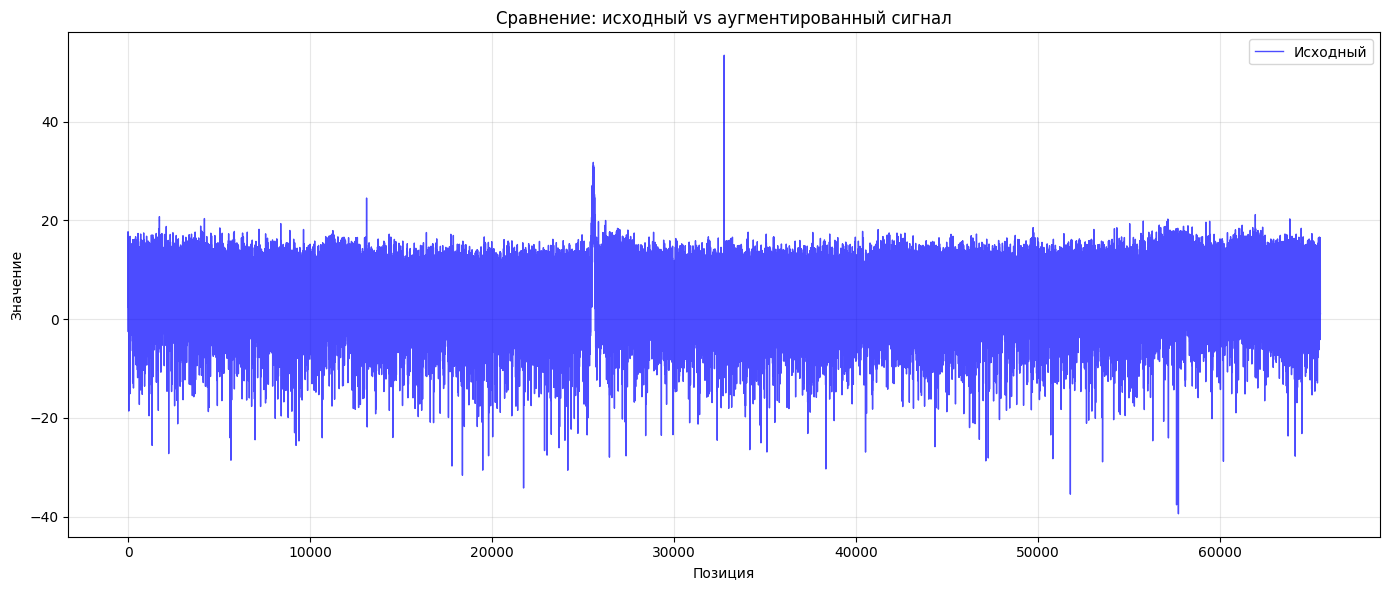

✅ Аугментированный файл сохранён: test.csv


In [9]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import random

# --- Настройки ---
filename = "435_1.csv"
output_filename = "test.csv"
row_index = 41  # индекс строки (0 — заголовок, 1 — первая строка данных и т.д.)

# --- Загрузка строки ---
with open(filename, 'r', encoding='cp1251') as f:
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)

data_row = rows[row_index]
values = np.array([float(x) for x in data_row if x.strip() != ''])

print(f"Исходная длина: {len(values)}")

# --- Аугментация: сохраняем форму, но немного искажаем ---
def augment_signal(x, noise_level=0.01, amp_factor_range=(0.95, 1.05), shift_max=20):
    """
    x: исходный сигнал (numpy array)
    noise_level: уровень гауссовского шума (относительно std)
    amp_factor_range: случайный множитель амплитуды
    shift_max: макс. сдвиг пика влево/вправо (в отсчётах)
    """
    x = x.copy()

    # 1. Добавляем небольшой шум
    noise = np.random.normal(0, noise_level * np.std(x), x.shape)
    x += noise

    # 2. Случайное изменение амплитуды
    amp_factor = np.random.uniform(*amp_factor_range)
    x *= amp_factor

    # 3. Мягкий сдвиг сигнала (циклический или с заполнением)
    shift = np.random.randint(-shift_max, shift_max + 1)
    if shift != 0:
        if shift > 0:
            x = np.concatenate([np.full(shift, x[0]), x[:-shift]])
        else:
            x = np.concatenate([x[-shift:], np.full(-shift, x[-1])])

    return x

# Применяем аугментацию
values_aug = augment_signal(
    values,
    noise_level=0.02,        # 2% от std — мягкий шум
    amp_factor_range=(0.98, 1.02),  # ±2% амплитуды
    shift_max=30             # сдвиг до 30 точек
)

# --- Визуализация ---
plt.figure(figsize=(14, 6))
plt.plot(values, label='Исходный', linewidth=1, color='blue', alpha=0.7)
# plt.plot(values_aug, label='Аугментированный', linewidth=1, color='red', alpha=0.8)
plt.title("Сравнение: исходный vs аугментированный сигнал")
plt.xlabel("Позиция")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Сохранение в новый CSV (с тем же заголовком) ---
with open(filename, 'r', encoding='cp1251') as f:
    header_line = f.readline()  # первая строка — заголовок

# Записываем новый файл
with open(output_filename, 'w', encoding='cp1251') as f:
    f.write(header_line)  # сохраняем заголовок
    # Заменяем только нужную строку
    for i, row in enumerate(rows):
        if i == row_index:
            # Преобразуем аугментированные значения в строки
            augmented_row = ['{:.15f}'.format(v) for v in values_aug]
            f.write(';'.join(augmented_row) + '\n')
        else:
            # Остальные строки — как есть
            f.write(';'.join(row) + '\n')

print(f"✅ Аугментированный файл сохранён: {output_filename}")

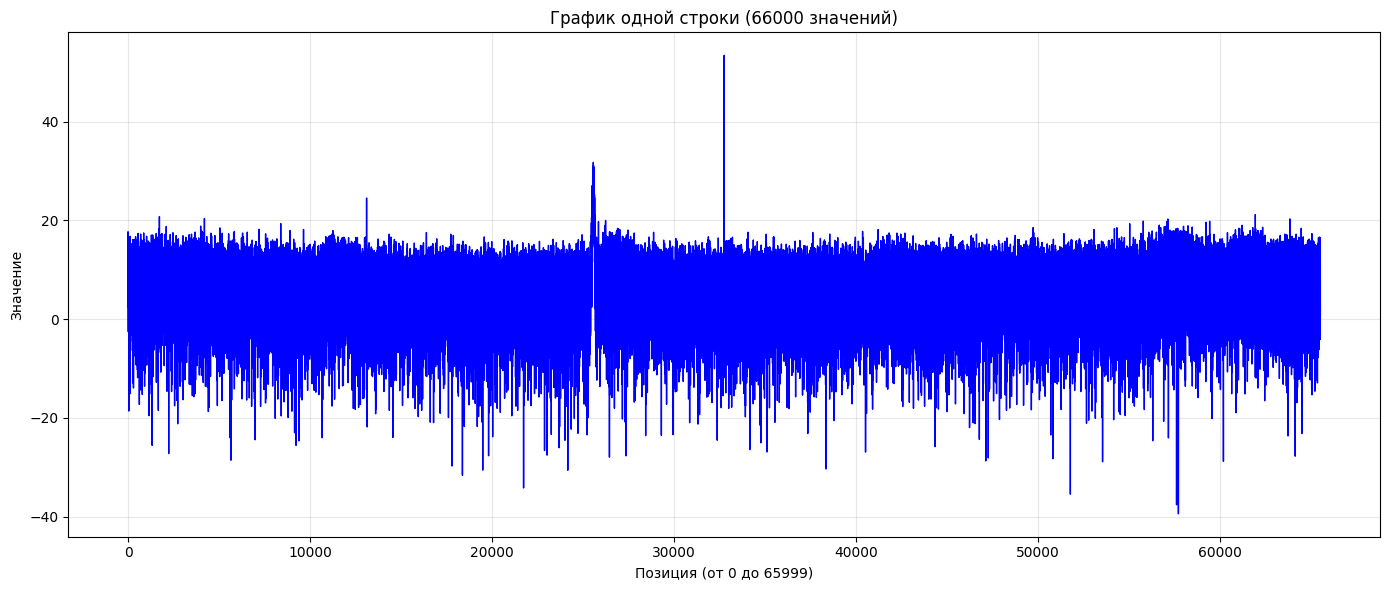

In [6]:
import matplotlib.pyplot as plt
import csv

# Путь к файлу (замените на свой)
filename = "435_1.csv"

# Читаем файл
with open(filename, 'r', encoding='cp1251') as f:
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)

# Берём вторую строку (индекс 1) — это первая строка с данными
data_row = rows[41]
# Преобразуем в числа
values_0 = [float(x) for x in data_row]

# Строим график
plt.figure(figsize=(14, 6))
plt.plot(values_0, linewidth=1, color='blue')
plt.title("График одной строки (66000 значений)")
plt.xlabel("Позиция (от 0 до 65999)")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1. Загрузка и объединение данных
# ----------------------------

def load_csv_signals(filename, delimiter=';', encoding='cp1251'):
    with open(filename, 'r', encoding=encoding) as f:
        lines = f.readlines()
    
    # Пропускаем первую строку (заголовок)
    data_lines = lines[1:]
    
    data = []
    expected_len = None
    
    for i, line in enumerate(data_lines, start=2):  # строки начинаются с 2
        if not line.strip():
            continue
        parts = [x.strip() for x in line.split(delimiter)]
        # Удаляем пустые элементы в конце (частая причина ошибки!)
        while parts and parts[-1] == '':
            parts.pop()
        
        if expected_len is None:
            expected_len = len(parts)
            print(f"Ожидаемая длина сигнала: {expected_len}")
        elif len(parts) != expected_len:
            print(f"⚠️  Строка {i}: ожидается {expected_len}, найдено {len(parts)} — пропускаем или обрезаем")
            # Вариант A: пропустить строку
            # continue
            # Вариант B: обрезать/дополнить до нужной длины
            if len(parts) > expected_len:
                parts = parts[:expected_len]
            else:
                parts += ['0'] * (expected_len - len(parts))
        
        try:
            row = [float(x) for x in parts]
            data.append(row)
        except ValueError as e:
            print(f"❌ Ошибка в строке {i}: {e} — пропускаем")
            continue
    
    return np.array(data, dtype=np.float32)   

# Укажи пути к своим файлам
files = {
    'pos_f1': '315_0.csv',
    'neg_f1': '315_1.csv',
    'pos_f2': '435_0.csv',
    'neg_f2': '435_1.csv'
}

# Загружаем
X_pos_f1 = load_csv_signals(files['pos_f1'])   # (N1, T)
X_neg_f1 = load_csv_signals(files['neg_f1'])   # (N2, T)
X_pos_f2 = load_csv_signals(files['pos_f2'])   # (N3, T)
X_neg_f2 = load_csv_signals(files['neg_f2'])   # (N4, T)

# Проверим, что длина сигнала одинаковая
T = X_pos_f1.shape[1]
assert all(arr.shape[1] == T for arr in [X_neg_f1, X_pos_f2, X_neg_f2]), "Длина сигналов не совпадает!"

print(f"Длина сигнала: {T} точек")
print(f"Примеры: f1+={X_pos_f1.shape[0]}, f1-={X_neg_f1.shape[0]}, f2+={X_pos_f2.shape[0]}, f2-={X_neg_f2.shape[0]}")


In [24]:
import numpy as np

def clean_and_center_signal(parts, target_length):
    """
    parts: список строковых значений из одной строки CSV (после split(';'))
    target_length: целевая длина сигнала (например, 65537)
    
    Возвращает:
        numpy array длины target_length или None (если невозможно обработать)
    """
    # 1. Удаляем пустые и пробельные элементы
    cleaned = [x.strip() for x in parts if x.strip() != '']
    
    if len(cleaned) == 0:
        return None
    
    # 2. Преобразуем в числа
    try:
        signal = np.array(cleaned, dtype=np.float32)
    except ValueError:
        return None  # битые данные
    
    L = len(signal)
    
    # 3. Обработка длины
    if L == target_length:
        return signal
    
    elif L > target_length:
        # Сигнал длиннее → обрезаем симметрично (с краёв)
        excess = L - target_length
        start = excess // 2
        end = start + target_length
        return signal[start:end]
    
    else:
        # Сигнал короче → дополняем (редкий случай)
        # Дополним средним значением (можно заменить на 0)
        pad = target_length - L
        pad_left = pad // 2
        pad_right = pad - pad_left
        mean_val = signal.mean() if L > 0 else 0.0
        return np.pad(signal, (pad_left, pad_right), mode='constant', constant_values=mean_val)

In [25]:
def load_and_align_file(filename, target_length, delimiter=';', encoding='cp1251'):
    """
    Загружает файл, пропускает заголовок, обрабатывает каждую строку.
    Возвращает: np.array формы (N_valid, target_length)
    """
    signals = []
    
    with open(filename, 'r', encoding=encoding) as f:
        lines = f.readlines()
    
    for line_idx, line in enumerate(lines[1:], start=2):  # пропускаем заголовок
        line = line.strip()
        if not line:
            continue
        
        parts = line.split(delimiter)
        sig = clean_and_center_signal(parts, target_length)
        
        if sig is not None:
            signals.append(sig)
        else:
            print(f"⚠️ Пропущена строка {line_idx} в {filename}")
    
    return np.array(signals, dtype=np.float32) if signals else np.empty((0, target_length))

In [26]:
def estimate_target_length(filenames, delimiter=';', encoding='cp1251'):
    lengths = []
    for fname in filenames:
        with open(fname, 'r', encoding=encoding) as f:
            lines = f.readlines()
        for line in lines[1:]:
            parts = [x.strip() for x in line.split(delimiter) if x.strip() != '']
            if parts:
                lengths.append(len(parts))
    
    from scipy import stats
    mode_len = int(stats.mode(lengths, keepdims=False).mode)
    print(f"💡 Оценка целевой длины по моде: {mode_len} (встречается {lengths.count(mode_len)} раз из {len(lengths)})")
    return mode_len

In [ ]:
# Список всех файлов
all_files = ['315_0.csv', '315_1.csv', '435_0.csv', '435_1.csv']

# 1. Определяем целевую длину
target_len = estimate_target_length(all_files)

# 2. Загружаем классы
neg_files = ['315_0.csv', '435_0.csv']   # класс 0
pos_files = ['315_1.csv', '435_1.csv']   # класс 1

X_neg = np.vstack([load_and_align_file(f, target_len) for f in neg_files])
X_pos = np.vstack([load_and_align_file(f, target_len) for f in pos_files])

print(f"Загружено: neg={X_neg.shape[0]}, pos={X_pos.shape[0]} сигналов длиной {target_len}")

💡 Оценка целевой длины по моде: 65536 (встречается 242 раз из 260)
Загружено: neg=128, pos=132 сигналов длиной 65536


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Для отрицательных (класс 0) ---
X_neg_train, X_neg_test = train_test_split(
    X_neg, test_size=0.2, random_state=42, stratify=None
)

# --- Для положительных (класс 1) ---
X_pos_train, X_pos_test = train_test_split(
    X_pos, test_size=0.2, random_state=42, stratify=None
)

print(f"Train: neg={X_neg_train.shape[0]}, pos={X_pos_train.shape[0]}")
print(f"Test:  neg={X_neg_test.shape[0]}, pos={X_pos_test.shape[0]}")
# --- Train: объединяем негативы и позитивы ---
X_train = np.vstack([X_neg_train, X_pos_train])
y_train = np.hstack([
    np.zeros(X_neg_train.shape[0]),   # 0 — фон
    np.ones(X_pos_train.shape[0])     # 1 — сигнал
])

# --- Test: то же самое ---
X_test = np.vstack([X_neg_test, X_pos_test])
y_test = np.hstack([
    np.zeros(X_neg_test.shape[0]),
    np.ones(X_pos_test.shape[0])
])
# Перемешиваем train и test НЕЗАВИСИМО
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)
print("\n=== Итоговые наборы ===")
print(f"Train: {X_train.shape[0]} примеров → {int(y_train.sum())} положительных, {int((1-y_train).sum())} отрицательных")
print(f"Test:  {X_test.shape[0]} примеров → {int(y_test.sum())} положительных, {int((1-y_test).sum())} отрицательных")



Train: neg=102, pos=105
Test:  neg=26, pos=27

=== Итоговые наборы ===
Train: 207 примеров → 105 положительных, 102 отрицательных
Test:  53 примеров → 27 положительных, 26 отрицательных


In [31]:
from scipy.signal import savgol_filter

def smooth_signal(signal, window=101, polyorder=3):
    """
    Применяет фильтр Савицкого-Голея к одному сигналу.
    
    Параметры:
        signal: numpy array (T,)
        window: размер окна (нечётное число, чем больше — сильнее сглаживание)
        polyorder: степень полинома (обычно 2-3)
    """
    if window % 2 == 0:
        window += 1  # должно быть нечётным
    
    # Если сигнал короче окна — уменьшаем окно
    if len(signal) < window:
        window = len(signal) - 1 if len(signal) % 2 == 0 else len(signal)
        if window <= polyorder:
            return signal  # не фильтруем, если слишком мало точек
    
    return savgol_filter(signal, window_length=window, polyorder=polyorder)

In [35]:
from scipy.signal import savgol_filter
import numpy as np

def apply_savgol_to_dataset(X, window=101, polyorder=3):
    """
    Применяет фильтр Савицкого-Голея ко всем сигналам в X.
    X: numpy array формы (N_samples, signal_length)
    Возвращает: X_smooth — той же формы, но сглаженный.
    """
    X_smooth = np.empty_like(X)
    win = window if window % 2 == 1 else window + 1  # окно должно быть нечётным
    
    for i in range(X.shape[0]):
        L = X.shape[1]
        # Убедимся, что окно не больше длины сигнала
        actual_win = min(win, L if L % 2 == 1 else L - 1)
        if actual_win <= polyorder:
            X_smooth[i] = X[i]  # не фильтруем, если невозможно
        else:
            X_smooth[i] = savgol_filter(X[i], window_length=actual_win, polyorder=polyorder)
    
    return X_smooth

# Применяем фильтр
print("Сглаживание обучающей выборки...")
X_train_smooth = apply_savgol_to_dataset(X_train, window=101, polyorder=3)

print("Сглаживание тестовой выборки...")
X_test_smooth = apply_savgol_to_dataset(X_test, window=101, polyorder=3)

print("✅ Сглаживание завершено!")

# === Сохраняем ВСЁ в файлы ===
print("Сохранение данных...")

# Сглаженные сигналы
np.save("X_train_smooth.npy", X_train_smooth.astype(np.float32))
np.save("X_test_smooth.npy", X_test_smooth.astype(np.float32))

# Метки (они не менялись, но сохраним для полноты)
np.save("y_train.npy", y_train.astype(np.float32))
np.save("y_test.npy", y_test.astype(np.float32))

print("✅ Все файлы сохранены:")
print("   - X_train_smooth.npy")
print("   - X_test_smooth.npy")
print("   - y_train.npy")
print("   - y_test.npy")

Сглаживание обучающей выборки...
Сглаживание тестовой выборки...
✅ Сглаживание завершено!
Сохранение данных...
✅ Все файлы сохранены:
   - X_train_smooth.npy
   - X_test_smooth.npy
   - y_train.npy
   - y_test.npy


In [ ]:
import matplotlib.pyplot as plt

# Возьмём первый сигнал из train
i = 0
plt.figure(figsize=(12, 4))
plt.plot(X_train[i], label='Исходный', alpha=0.7, linewidth=1)
plt.plot(X_train_smooth[i], label='Сглаженный', linewidth=1.5)
plt.title(f"Сигнал {i} (метка: {int(y_train[i])})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()